# SELECCIÓN DE ZONA APTA CON MEJOR APTITUD PARA EL CULTIVO DEL CAFÉ


![Logo_UN](https://th.bing.com/th/id/OIP.sbwDgZOlC3XOF4f6djxpIgHaC0?w=350&h=133&c=7&r=0&o=5&cb=iwc2&pid=1.7)

# Desarrollo Taller: 7. Project – Bringing it all together 

#### Facultad de Ciencias Agrarias
#### Maestria en Geomática.
#### Universidad Nacional de Colombia

 Estudiante: Meyi Paola Bacca //
 Docente: Liliana Carolina Castillo Villamor 

#### Objetivo del taller:
Evaluar cuán eficazmente las distintas capas de geometria vectorial y dataframers que nos permita hallar el municipio con mejor aptitud para el cultivo de Café.

## Prerequisites  
This notebook willl use the following datasets

| File | Description | CRS / key fields |
|------|-------------|------------------|
| `Catalogo_Estaciones_IDEAM.csv` | IDEAM meteorological‑station catalogue (lon, lat, alt) | WGS 84 |
| `Evaluaciones_Agropecuarias_Municipales_EVA.csv` | Municipal agricultural production statistics | `COD_MPIO`, crop, area, production |
| `precipitacion.csv` | Daily precipitation per station | Station ID, date, value |
| `municipios_colombia.shp` | Colombian municipalities | EPSG 3116 (MAGNA‑Sirgas / Colombia Bogotá) |
| `runap.shp` | Áreas de protección ambiental | EPSG 3116 (MAGNA‑Sirgas / Colombia Bogotá) |

Activate the environment and launch **Jupyter Lab** before running the cells below.

## 1  Introduction  
- Haciendo uso de operaciones espaciales se plantean distintas preguntas tales como ¿que municipios tienen mejor aptitud del cultivo del café?, de las capas intersectantes ¿Cuantas y cueles son las estaciones del iden que intersectan contales municipios?
- interactura con las capas de tal manera que se pueda interactuar con las geométrias, simplificando los limites, creando nuevas zonas de influencias. 

## 2. Importar Librarias

In [37]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

plt.rcParams['figure.figsize'] = (10, 8)


## 3. Cargar y armonizar los datos

Importamos los tres archivos fuente, ordenamos algunas columnas y nos aseguramos de que **todas las capas espaciales** se proyecten a *MAGNA-SIRGAS Origen Nacional*
(**EPSG 9377**).

In [38]:
# --- File paths  ---
root_folder = r"/notebooks"  # la ruta de ubicación
#root_folder=r"/Users/macbook/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres"

SHAPE_MUN = root_folder+'/municipios_colombia.shp'
EVA_CSV   = root_folder+'/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV   = root_folder+'/Catalogo_Estaciones_IDEAM.csv'
SHAPE_VIAS= root_folder+'/Workshop_6/vias/vias.shp'
SHAPE_RUNAP=root_folder+'/Workshop_6/latest/runap.shp'


## 3.1. Cargar y armonizar los datos

La ​​tabla EVA no tiene coordenadas, pero renombramos su código de municipio
a `cod_mun` para mantener la coherencia.

In [39]:
# Municipalities → GeoDataFrame 
gdf_mun = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)

# Municipalities → GeoDataFrame 
gdf_vias = gpd.read_file(SHAPE_VIAS).to_crs(epsg=9377)

# Municipalities → GeoDataFrame 
gdf_runap = gpd.read_file(SHAPE_RUNAP).to_crs(epsg=9377)


# EVA table, rename code column
eva = (pd.read_csv(EVA_CSV)
         .rename(columns={"CÓD. MUN.": "cod_mun"}))
eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

# IDEAM catalogue → GeoDataFrame (clean "(lat, lon)")
df_est = pd.read_csv(EST_CSV, encoding="utf-8", sep=',')
coords = (df_est["Ubicación"]
            .str.strip("()")
            .str.split(",", expand=True)
            .astype(float))
df_est["lat"], df_est["lon"] = coords[0], coords[1]

print(df_est.columns.tolist())  # Asegúrate de que se llama exactamente 'Ubicación'
print(df_est["Ubicación"].head())


gdf_est = gpd.GeoDataFrame(
    df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=9377)

print(f"{len(gdf_mun):,} municipalities • {len(gdf_est):,} stations • "
      f"{len(eva):,} EVA rows")


#Homogenise municipalities codes
gdf_mun["MPIO_CCDGO"] = gdf_mun["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]        = eva["cod_mun"].astype(str).str.zfill(5)

['Codigo', 'Nombre', 'Categoria', 'Estado', 'Departamento', 'Municipio', 'Ubicación', 'Altitud', 'Fecha_instalacion', 'Fecha_suspension', 'Corriente', 'lat', 'lon']
0     (0.81378611, -77.66197778)
1     (0.93030556, -77.49119444)
2     (1.07061111, -77.63688889)
3     (1.08288889, -76.66711111)
4    (-3.78030556, -70.36263889)
Name: Ubicación, dtype: object
1,122 municipalities • 8,973 stations • 206,068 EVA rows


## 3.2. Chequeo de los datos resultantes del la creación del gaodataframe `gdf_est`

ya que no solo se ejecutó la sustitucion de las columnas sino tambien se separó la columna de `Ubicación` papa generar 2 columnas nuevas con la informacion de latitud y longitud de manera separada, de tal manerqa qwue fuese mas facil darle una ubicacion en sistema crs=`EPSG:4326`


In [40]:
gdf_est

,Codigo,Nombre,Categoria,Estado,Departamento,Municipio,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,Corriente,lat,lon,geometry
0,52057100,RUMICHACA - AUT [52057100],Limnigráfica,Activa,Nariño,Ipiales,"(0.81378611, -77.66197778)",2582,2016-11-15,NaN,Guaitara,0.813786,-77.661978,POINT (4480921.418 1648261.853)
1,52055170,LA JOSEFINA - AUT [52055170],Climática Principal,Activa,Nariño,Contadero,"(0.93030556, -77.49119444)",2450,2005-12-10,NaN,Guaitara,0.930306,-77.491194,POINT (4499992.408 1661153.867)
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,Túquerres,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,Guaitara,1.070611,-77.636889,POINT (4483759.028 1676727.973)
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,Mocoa,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,Guaitara,1.082889,-76.667111,POINT (4591897.597 1677940.612)
4,48015040,PUERTO NARINO - AUT [48015040],Climática Principal,Activa,Amazonas,Puerto Nariño,"(-3.78030556, -70.36263889)",158,2005-07-19,NaN,Amazonas,-3.780306,-70.362639,POINT (5292824.016 1139928.729)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8968,4401700167,NIVEL SANGOYACO GARGANTA,Limnimétrica,Activa,Putumayo,Mocoa,"(1.15872222, -76.67080556)",761,2020-02-25,NaN,Mocoa,1.158722,-76.670806,POINT (4591496.422 1686336.979)
8969,4401700168,NIVEL MULATO PALMERAS,Limnimétrica,Activa,Putumayo,Mocoa,"(1.15638889, -76.69027778)",966,2020-02-25,NaN,Mocoa,1.156389,-76.690278,POINT (4589326.12 1686081.462)
8970,4401700172,NIVEL MOCOA PISCIKART,Limnimétrica,Activa,Putumayo,Villagarzón,"(1.03964167, -76.61091944)",408,2020-02-25,NaN,Mocoa,1.039642,-76.610919,POINT (4598153.817 1673145.302)
8971,4401700173,NIVEL RUMIYACO LAGARTO,Limnimétrica,Activa,Putumayo,Mocoa,"(1.119225, -76.67045)",647,2020-02-25,NaN,Mocoa,1.119225,-76.670450,POINT (4591530.468 1681964.004)


## 3.3. Join espacial entre la los Geodataframes `eva` y `gdf_mun`

Es importante generar el join espacial de estas dos capas geodataframe, ya que, hará mas facil las acciones entre las capas, detal manera que podabos g3enerar mapas de corropletas sobre información ` la informacion municipal de las estadisticas de produccion agricola` 

In [42]:
# Renombrar la columna para alinear con la clave de unión
eva = eva.rename(columns={'cod_mun': 'MPIO'})
print(eva.head())

# Asegurar que los códigos estén en formato de cadena y con ceros a la izquierda
eva['MPIO'] = eva['MPIO'].astype(str).str.zfill(5)
gdf_mun['MPIO_CDPMP'] = gdf_mun['MPIO_CDPMP'].astype(str).str.zfill(5)

# Realizar el join entre los datos espaciales de municipios y las evaluaciones agropecuarias
muni_eva = gdf_mun.merge(
    eva,
    how='left',                 # 'left' mantiene todos los municipios (incluso si no hay coincidencia con EVA)
    left_on='MPIO_CDPMP',       # Clave de unión en el GeoDataFrame (municipios)
    right_on='MPIO',            # Clave de unión en el DataFrame de EVA
    indicator=True,             # Crear una columna '_merge' para indicar el tipo de coincidencia
    validate='one_to_many',     # Validar que cada municipio en muni tenga como máximo una coincidencia en EVA
    suffixes=('', '_eva')       # Añadir el sufijo '_eva' a las columnas duplicadas
)

# Imprimir la cantidad de coincidencias
print(muni_eva['_merge'].value_counts())

# Mostrar las columnas después de la fusión
print(muni_eva.columns.tolist())

   CÓD. \nDEP.        DEPARTAMENTO   MPIO   MUNICIPIO GRUPO \nDE CULTIVO  \
0           15              BOYACA  15114    BUSBANZA         HORTALIZAS   
1           25        CUNDINAMARCA  25754      SOACHA         HORTALIZAS   
2           25        CUNDINAMARCA  25214        COTA         HORTALIZAS   
3           54  NORTE DE SANTANDER  54405  LOS PATIOS         HORTALIZAS   
4           54  NORTE DE SANTANDER  54518    PAMPLONA         HORTALIZAS   

  SUBGRUPO \nDE CULTIVO CULTIVO DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO  \
0                ACELGA  ACELGA                                        ACELGA   
1                ACELGA  ACELGA                                        ACELGA   
2                ACELGA  ACELGA                                        ACELGA   
3                ACELGA  ACELGA                                        ACELGA   
4                ACELGA  ACELGA                                        ACELGA   

    AÑO PERIODO  Área Sembrada\n(ha)  Área Cosechada\n(h

## 4. Operaciones espaciales sobre datos vectoriales

# 4.1. Evaluación de producción de café a lo largo del pais.
Se pretende identificar *cuales son los municipios con mayor proueccion de café* devuelve una nueva capa nueva llamada "cafe" donde se evidencian cual es la produccion de café por municipio, por lo anterior se aplica la función "dropna" la cual organiza de mayor a menor la columna de produccion de el cultivo de interes y generando un listado, muestr que el top1 es Pitaliti (Huila)

Filas conservadas para CAFE en 2018: 601
                  MPIO_CNMBR CULTIVO     AÑO
57                 FLORENCIA    CAFE  2018.0
514              EL DONCELLO    CAFE  2018.0
667                EL PAUJÍL    CAFE  2018.0
793             LA MONTAÑITA    CAFE  2018.0
1614  SAN VICENTE DEL CAGUÁN    CAFE  2018.0

🏆 Top 5 municipios con mayor producción de café (toneladas):
            MPIO_CNMBR  Producción\n(t)
171120        PITALITO          17236.0
180527         ACEVEDO          13472.0
59374   CIUDAD BOLÍVAR          11439.0
9882          EL TAMBO          11315.0
71338           SALGAR          11057.0


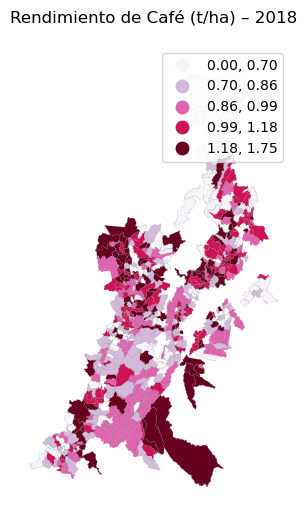

In [43]:

# Parámetros de cultivo y año
selected_year = 2018
crop_name     = 'CAFE'  # Asegúrate que en tu CSV esté sin tilde

# Filtrar por cultivo y año
cafe = (
    muni_eva
    .query("CULTIVO == @crop_name and AÑO == @selected_year")
    .copy()
)

# Verificación
print(f"Filas conservadas para {crop_name} en {selected_year}: {len(cafe):,}")
print(cafe[['MPIO_CNMBR', 'CULTIVO', 'AÑO']].head())

# Calcular rendimiento (t/ha)
cafe['yield_t_ha'] = (
    cafe['Producción\n(t)'] / cafe['Área Sembrada\n(ha)']
)

# Eliminar filas con valores nulos
cafe_map = cafe.dropna(subset=['yield_t_ha'])

# ▶ Mostrar los 5 municipios con mayor producción total de café
top5_produccion = (
    cafe_map[['MPIO_CNMBR', 'Producción\n(t)']]
    .sort_values(by='Producción\n(t)', ascending=False)
    .head(5)
)

print("\n🏆 Top 5 municipios con mayor producción de café (toneladas):")
print(top5_produccion)

# --- PARTE 3: Visualización del rendimiento --------------------------------

ax = cafe_map.plot(
    column='yield_t_ha',
    scheme='Quantiles', k=5,
    cmap='PuRd',
    legend=True,
    figsize=(6, 6),
    edgecolor='grey', linewidth=0.1
)
ax.set_title(f'Rendimiento de Café (t/ha) – {selected_year}')
ax.set_axis_off()
plt.show()

# 4.2 Subconjunto espacial
*El subconjunto espacial* devuelve una nueva capa que contiene solo las entidades con una relación espacial definida con otra capa.

Head of re-projected station GeoDataFrame:


,Codigo,Nombre,Categoria,Estado,Departamento,Municipio,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,Corriente,lat,lon,geometry
0,52057100,RUMICHACA - AUT [52057100],Limnigráfica,Activa,Nariño,Ipiales,"(0.81378611, -77.66197778)",2582,2016-11-15,NaN,Guaitara,0.813786,-77.661978,POINT (4480921.418 1648261.853)
1,52055170,LA JOSEFINA - AUT [52055170],Climática Principal,Activa,Nariño,Contadero,"(0.93030556, -77.49119444)",2450,2005-12-10,NaN,Guaitara,0.930306,-77.491194,POINT (4499992.408 1661153.867)
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,Túquerres,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,Guaitara,1.070611,-77.636889,POINT (4483759.028 1676727.973)
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,Mocoa,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,Guaitara,1.082889,-76.667111,POINT (4591897.597 1677940.612)
4,48015040,PUERTO NARINO - AUT [48015040],Climática Principal,Activa,Amazonas,Puerto Nariño,"(-3.78030556, -70.36263889)",158,2005-07-19,NaN,Amazonas,-3.780306,-70.362639,POINT (5292824.016 1139928.729)


gdf_mun columns Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION',
       'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO',
       'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO',
       'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M',
       'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N',
       'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N',
       'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA',
       'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI',
       'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC',
       'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2',
       'STP19_EE_3', 'STP19_EE_4', 'STP19_EE_5', 'STP19_EE_6', 'STP19_EE_9',
       'STP19_ACU1', 'STP19_ACU2', 'STP19_ALC1', 'STP19_ALC2', 'STP19_GAS1',
       'STP19_GAS2', 'STP19_GAS9', 'STP19_REC1', 'STP19_REC2', 'STP19_

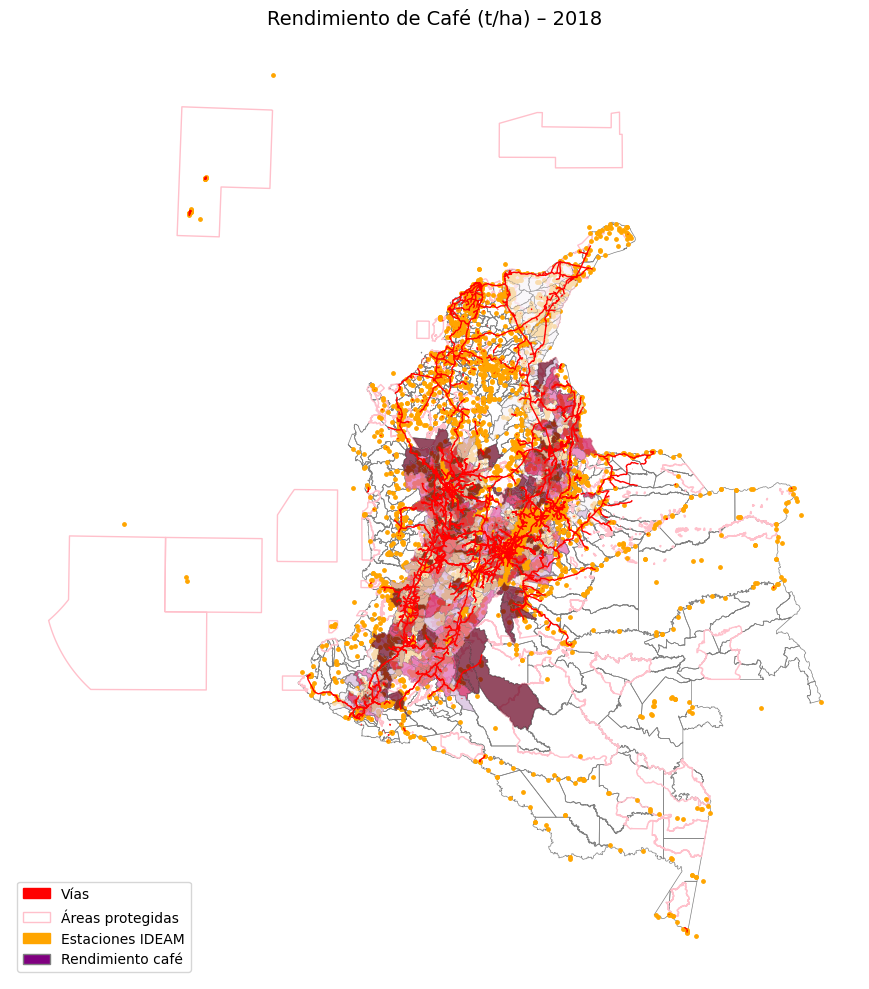

In [44]:
# ── Quick checks y carga del mapa base ─────────────────────────────────────
print("Head of re-projected station GeoDataFrame:")
display(gdf_est.head())
print("gdf_mun columns", gdf_mun.columns)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(10, 10))

# Mapa base: Municipios, vías, áreas protegidas, estaciones
gdf_mun.plot(ax=ax, color="none", edgecolor="grey", linewidth=0.5)
gdf_vias.plot(ax=ax, edgecolor="red", linewidth=1, label="Vías")
gdf_runap.plot(ax=ax, color="none", edgecolor="pink", linewidth=1, label="Áreas protegidas")
gdf_est.plot(ax=ax, color="orange", markersize=6, label="Estaciones IDEAM")

# ── Café: Filtrar por cultivo y año ────────────────────────────────────────
selected_year = 2018
crop_name     = 'CAFE'

cafe = (
    muni_eva
    .query("CULTIVO == @crop_name and AÑO == @selected_year")
    .copy()
)

print(f"Filas conservadas para {crop_name} en {selected_year}: {len(cafe):,}")
print(cafe[['MPIO_CNMBR', 'CULTIVO', 'AÑO']].head())

# Calcular rendimiento
cafe['yield_t_ha'] = (
    cafe['Producción\n(t)'] / cafe['Área Sembrada\n(ha)']
)


# Eliminar nulos
cafe_map = cafe.dropna(subset=['yield_t_ha'])

# Top 5 municipios con mayor producción
top5_produccion = (
    cafe_map[['MPIO_CNMBR', 'Producción\n(t)']]
    .sort_values(by='Producción\n(t)', ascending=False)
    .head(5)
)
print("\n🏆 Top 5 municipios con mayor producción de café (toneladas):")
print(top5_produccion)

# ── Visualización del rendimiento sobre el mismo ax ────────────────────────
cafe_map.plot(
    ax=ax,
    column='yield_t_ha',
    scheme='Quantiles', k=5,
    cmap='PuRd',
    legend=True,
    edgecolor='grey', linewidth=0.2,
    alpha=0.7  # Transparencia para ver capas inferiores
)

# Crear parches manuales para la leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Vías'),
    mpatches.Patch(edgecolor='pink', facecolor='none', label='Áreas protegidas'),
    mpatches.Patch(color='orange', label='Estaciones IDEAM'),
    mpatches.Patch(facecolor='purple', edgecolor='grey', label='Rendimiento café')
]

# Título y ajustes finales
ax.set_title(f'Rendimiento de Café (t/ha) – {selected_year}', fontsize=14)
ax.set_axis_off()
plt.legend(handles=legend_elements, loc='lower left')
plt.tight_layout()
plt.show()

# 4.3 Join espacial entre la capa de prodicion agricola de café (`cafe`) y el Geodataframe de estaciones del IDEAM
Este Join se hace con el find e consultar cuales de los municipios con mayor produccion de `cafe` tienen mayor concentracion o (intección) las demas capas de interes tales como: "áreas de protección ambiental", "Vias de acceso a tosod los ditintos territorios" y "las estaciones del IDEAM", ya que estas ultimas permitiria tener un control mas eficas de las condiciones climatologicas que se presenten en el municipio y cultivo de interes.

Contando estaciones por municipio...

Primeras 5 filas del conteo:
  MPIO_CCDGO  num_estaciones
0      00001              17
1      00002               1
2      00003               1
3      00004               1
4      00006               2

Primeras 5 filas del conteo:
  MPIO_CCDGO  num_estaciones
0      00001              17
1      00002               1
2      00003               1
3      00004               1
4      00006               2
Top 5 municipios con más estaciones:
    MPIO_CCDGO  num_estaciones
0        00001              17
195      00400               5
317      00686               4
338      00770               4
6        00013               4


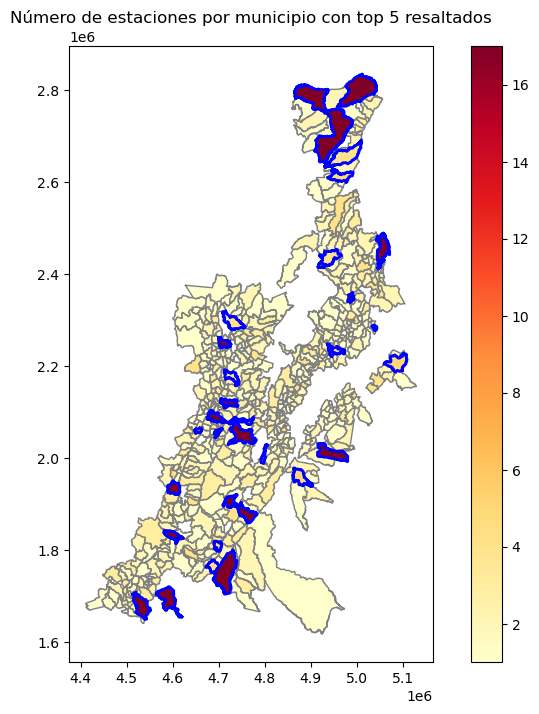


Información detallada de los top 5 municipios y sus uniones espaciales:

• FLORENCIA (Código: 00001): 17 estaciones
  - Estaciones que intersectan: 20
  - Vías que intersectan: 9
  - Áreas protegidas que intersectan: 24

• LA UNIÓN (Código: 00400): 5 estaciones
  - Estaciones que intersectan: 19
  - Vías que intersectan: 9
  - Áreas protegidas que intersectan: 1

• SANTA ROSA DE OSOS (Código: 00686): 4 estaciones
  - Estaciones que intersectan: 39
  - Vías que intersectan: 14
  - Áreas protegidas que intersectan: 6

• SAN MARTÍN (Código: 00770): 4 estaciones
  - Estaciones que intersectan: 2
  - Vías que intersectan: 6
  - Áreas protegidas que intersectan: 0

• AGUADAS (Código: 00013): 4 estaciones
  - Estaciones que intersectan: 14
  - Vías que intersectan: 5
  - Áreas protegidas que intersectan: 3


In [45]:
# Realizar el join espacial correctamente
est_muni = gpd.sjoin(gdf_est, cafe, how="left", predicate="within")

print("Contando estaciones por municipio...")
est_por_muni = cafe.groupby("MPIO_CCDGO").size()

# Convertir la Serie a DataFrame y renombrar columna
conteo_df = est_por_muni.reset_index(name="num_estaciones")
print("\nPrimeras 5 filas del conteo:")
print(conteo_df.head())



# Convertir la Serie a DataFrame y renombrar columna
pitalito_cont = est_por_muni.reset_index(name="num_estaciones")
print("\nPrimeras 5 filas del conteo:")
print(conteo_df.head())



# Ordenar por num_estaciones de mayor a menor y tomar los primeros 5
top5 = conteo_df.sort_values(by="num_estaciones", ascending=False).head(5)
print("Top 5 municipios con más estaciones:")
print(top5)

# Unir datos al GeoDataFrame de municipios
gdf_mun_est = cafe.merge(
    conteo_df,
    left_on="MPIO_CCDGO",
    right_on="MPIO_CCDGO",
    how="left"
)

# Añadir columna booleana para resaltar top 5
gdf_mun_est["highlight"] = gdf_mun_est["MPIO_CCDGO"].isin(top5["MPIO_CCDGO"])

# Graficar mapa temático con resaltado
fig, ax = plt.subplots(figsize=(10, 8))
gdf_mun_est.plot(
    column="num_estaciones",
    cmap="YlOrRd",
    legend=True,
    ax=ax,
    missing_kwds={"color": "lightgrey"},
    edgecolor="grey"
)
highlight_munis = gdf_mun_est[gdf_mun_est["highlight"]]
highlight_munis.plot(
    ax=ax,
    facecolor="none",
    edgecolor="blue",
    linewidth=2
)
plt.title("Número de estaciones por municipio con top 5 resaltados")
plt.show()

# --- Uniones booleanas para los top 5 municipios ---
print("\nInformación detallada de los top 5 municipios y sus uniones espaciales:")
for idx, row in top5.iterrows():
    cod_mun = row["MPIO_CCDGO"]
    nombre = cafe.loc[cafe["MPIO_CCDGO"] == cod_mun, "MPIO_CNMBR"].values[0]
    muni_geom = cafe.loc[cafe["MPIO_CCDGO"] == cod_mun].geometry.iloc[0]
    
    # Máscaras booleanas espaciales
    estaciones_bool = gdf_est.intersects(muni_geom)
    vias_bool = gdf_vias.intersects(muni_geom)
    runap_bool = gdf_runap.intersects(muni_geom)
    
    print(f"\n• {nombre} (Código: {cod_mun}): {row['num_estaciones']} estaciones")
    print(f"  - Estaciones que intersectan: {estaciones_bool.sum()}")
    print(f"  - Vías que intersectan: {vias_bool.sum()}")
    print(f"  - Áreas protegidas que intersectan: {runap_bool.sum()}")


   
# Mostrar información detallada de los municipios
# print("\nInformación detallada de los top 5 municipios:")
#for idx, row in gdf_top5_final.iterrows():
#    print(f"• {row.get('MPIO_CNMBR', 'N/A')} (Código: {row['MPIO_CCDGO']}): {row['num_estaciones']} estaciones")

# 4.4 Revision de la generacion del Join espacial entre estaciones del IDEAM y los municipios productores de café

In [46]:
# Asegurar que ambas capas tengan el mismo CRS (muy importante para el join espacial)
print("CRS estaciones:", gdf_est.crs)
print("CRS municipios con café:", cafe.crs)

# Alinear CRS si es necesario
if gdf_est.crs != cafe.crs:
    gdf_est = gdf_est.to_crs(cafe.crs)

# Realizar el join espacial correctamente: estaciones dentro de municipios con café
est_muni = gpd.sjoin(gdf_est, cafe, how="inner", predicate="within")

# Mostrar primeros registros resultantes del join
print("\n🔗 Resultado del spatial join (estaciones dentro de municipios con café):")
display(est_muni.head())

# Contar cuántas estaciones hay por municipio (usando código de municipio de la tabla 'cafe')
print("\nContando estaciones por municipio con café...")
est_por_muni = est_muni.groupby("MPIO_CCDGO").size()

# Convertir a DataFrame y renombrar columna
conteo_df = est_por_muni.reset_index(name="num_estaciones")

# Mostrar resultados
print("\n📊 Número de estaciones IDEAM por municipio con café en 2018:")
print(conteo_df.sort_values(by="num_estaciones", ascending=False).head())


CRS estaciones: EPSG:9377
CRS municipios con café: EPSG:9377

🔗 Resultado del spatial join (estaciones dentro de municipios con café):


,Codigo,Nombre,Categoria,Estado,Departamento,Municipio,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,...,PERIODO,Área Sembrada\n(ha),Área Cosechada\n(ha),Producción\n(t),Rendimiento\n(t/ha),ESTADO FISICO PRODUCCION,NOMBRE \nCIENTIFICO,CICLO DE CULTIVO,_merge,yield_t_ha
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,Túquerres,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,...,2018,40.0,37.0,32.0,0.86,CAFE VERDE EQUIVALENTE,COFFEA ARABICA,PERMANENTE,both,0.800000
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,Mocoa,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,...,2018,222.0,210.0,289.0,1.38,CAFE VERDE EQUIVALENTE,COFFEA ARABICA,PERMANENTE,both,1.301802
8,44037040,EL ROSARIO - AUT [44037040],Limnigráfica,Activa,Caquetá,Florencia (Caquetá),"(1.72525, -75.66638889)",600,1964-08-15,NaN,...,2018,1122.0,1004.0,1038.0,1.03,CAFE VERDE EQUIVALENTE,COFFEA ARABICA,PERMANENTE,both,0.925134
9,52077020,LOS NORTES - AUT [52077020],Limnigráfica,Activa,Nariño,Cumbitara,"(1.74111111, -77.53111111)",340,1984-09-15,NaN,...,2018,64.0,64.0,66.0,1.03,CAFE VERDE EQUIVALENTE,COFFEA ARABICA,PERMANENTE,both,1.031250
11,21017050,PITALITO 2 - AUT [21017050],Limnigráfica,Activa,Huila,Pitalito,"(1.84883333, -76.05244444)",1250,1972-05-15,NaN,...,2018,18319.0,15150.0,17236.0,1.14,CAFE VERDE EQUIVALENTE,COFFEA ARABICA,PERMANENTE,both,0.940881



Contando estaciones por municipio con café...

📊 Número de estaciones IDEAM por municipio con café en 2018:
    MPIO_CCDGO  num_estaciones
0        00001             764
243      00520              94
6        00013              72
244      00524              55
305      00682              54


# 4.4.1 Consulta de los elementos que interactuan con el mayor productor de `café` el cual es `Pitalito (Huila)`


In [47]:
# --- Análisis espacial para el municipio de Pitalito ---
# Asegurar que el nombre esté bien escrito y codificado según el campo MPIO_CNMBR
pitalito_geom = cafe.loc[cafe["MPIO_CNMBR"].str.upper() == "PITALITO"].geometry.iloc[0]

# Verificar el código de municipio, si también lo necesitas
pitalito_cod = cafe.loc[cafe["MPIO_CNMBR"].str.upper() == "PITALITO", "MPIO_CCDGO"].values[0]
print(f"\n📌 Municipio: Pitalito (Código: {pitalito_cod})")

# Aplicar intersecciones espaciales
estaciones_pitalito = gdf_est[gdf_est.intersects(pitalito_geom)]
vias_pitalito = gdf_vias[gdf_vias.intersects(pitalito_geom)]
runap_pitalito = gdf_runap[gdf_runap.intersects(pitalito_geom)]

# Mostrar conteos
print("\n🔍 Resultados de intersección con el municipio de Pitalito:")
print(f"- Estaciones del IDEAM: {len(estaciones_pitalito)}")
print(f"- Vías: {len(vias_pitalito)}")
print(f"- Áreas protegidas: {len(runap_pitalito)}")



📌 Municipio: Pitalito (Código: 00551)

🔍 Resultados de intersección con el municipio de Pitalito:
- Estaciones del IDEAM: 13
- Vías: 13
- Áreas protegidas: 8


# 4.5 Visualización general del la ubicacion del municipio de `Pitalito (Huila)`

/tmp/ipykernel_72/1857459603.py:41: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc="upper right", fontsize=10)
/tmp/ipykernel_72/1857459603.py:50: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc="upper right", fontsize=10)


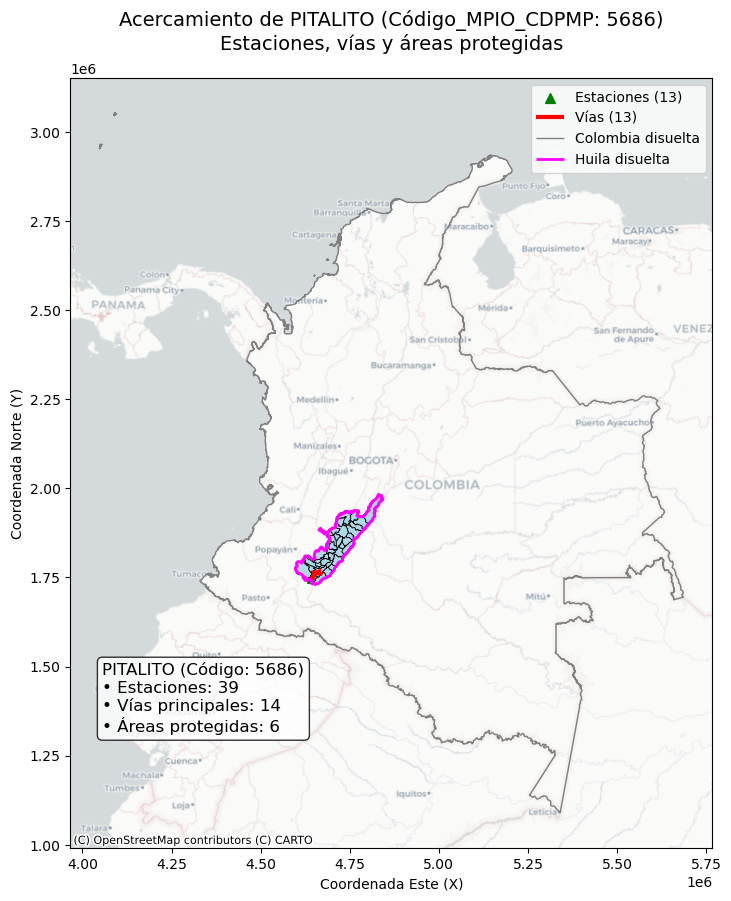

In [48]:
# 2. GeoDataFrame de los municipios de huila
gdf_huila = gdf_mun[gdf_mun["DPTO_CCDGO"] == "41"].copy()

# 3. GeoDataFrame con el borde del departamento de Huila (disuelto)
huila_borde = gdf_huila.dissolve(by="DPTO_CCDGO")

# 4. GeoDataFrame con el borde de toda Colombia (disuelto)
colombia_borde = gdf_mun.dissolve()




# Filtrar el GeoDataFrame para el municipio de PITALITO usando su código
pitalito_muni = cafe[cafe["MPIO_CDPMP"] == "41551"].copy()

# Crear máscaras booleanas para elementos que intersectan con PITALITO
pitalito_stations = gdf_est[gdf_est.intersects(pitalito_muni.geometry.iloc[0])]
pitalito_vias = gdf_vias[gdf_vias.intersects(pitalito_muni.geometry.iloc[0])]
pitalito_runap = gdf_runap[gdf_runap.intersects(pitalito_muni.geometry.iloc[0])]

#cortar la via
cort_via = gpd.clip(pitalito_vias, pitalito_muni)
# Crear el mapa de acercamiento
fig, ax = plt.subplots(figsize=(12, 10))

# Graficar elementos
pitalito_muni.plot(ax=ax, color="lightgray", edgecolor="black")  # Fondo del municipio
pitalito_stations.plot(ax=ax, color="green", markersize=50, marker="^", label="Estaciones (13)")
cort_via.plot(ax=ax, color="red", linewidth=3, label="Vías (13)")
pitalito_runap.plot(ax=ax, color="blue", alpha=0.5, edgecolor="navy", label="Áreas protegidas (8)")

colombia_borde.boundary.plot(ax=ax, edgecolor="gray", linewidth=1, label="Colombia disuelta")
gdf_huila.plot(ax=ax, color="lightblue", edgecolor="black", linewidth=0.5, label="Municipios Huila")
huila_borde.boundary.plot(ax=ax, edgecolor="magenta", linewidth=2, label="Huila disuelta")

# Añadir detalles
ctx.add_basemap(ax, crs=pitalito_muni.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.title("Vista general de PITALITO (Código_MPIO_CDPMP: 41551)\nEstaciones, vías y áreas protegidas", fontsize=14, pad=20)
plt.legend(loc="upper right", fontsize=10)
ax.set_axis_on()  # Activa los ejes
ax.ticklabel_format(useOffset=False)  # Desactiva notación científica si aplica
ax.set_xlabel("Coordenada Este (X)")
ax.set_ylabel("Coordenada Norte (Y)")

# Añadir detalles
ctx.add_basemap(ax, crs=pitalito_muni.crs.to_string(), source=ctx.providers.CartoDB.Positron)
plt.title("Acercamiento de PITALITO (Código_MPIO_CDPMP: 5686)\nEstaciones, vías y áreas protegidas", fontsize=14, pad=20)
plt.legend(loc="upper right", fontsize=10)

# Activar ejes con coordenadas
ax.set_axis_on()
ax.ticklabel_format(useOffset=False)
ax.set_xlabel("Coordenada Este (X)")
ax.set_ylabel("Coordenada Norte (Y)")

# Añadir anotación con información del municipio
info_text = (
    "PITALITO (Código: 5686)\n"
    "• Estaciones: 39\n"
    "• Vías principales: 14\n"
    "• Áreas protegidas: 6"
)
plt.annotate(info_text, 
             xy=(0.05, 0.15), 
             xycoords='axes fraction',
             fontsize=12,
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

plt.show()

# 4.6 Visualización de los mayores productores del Café del departamento del Huila, cerificando que el mayor productor es `Pitalito (Huila)`

Municipios del Huila con cultivo de café en 2018: 35
          MPIO_CNMBR  Producción\n(t)  yield_t_ha
165015         NEIVA           3821.0    0.905880
165607       GIGANTE           4628.0    0.844217
166203     GUADALUPE           4809.0    0.947773
166633          HOBO            979.0    0.970268
167071        ÍQUIRA           2391.0    0.936912
167446         ISNOS           4096.0    0.931968
167845  LA ARGENTINA           2326.0    0.902600
168230      LA PLATA          10234.0    0.913261
168768        NÁTAGA           1804.0    0.894841
169142       OPORAPA           2937.0    0.941346
169496        PAICOL           1598.0    0.912100
169837       PALERMO           2427.0    0.961188
170232     PALESTINA           4554.0    0.935497
170631         PITAL           4373.0    0.919470
171120      PITALITO          17236.0    0.940881
171606        RIVERA            694.0    0.937838
172134  SALADOBLANCO           3109.0    0.901159
172475   SAN AGUSTÍN           5050.0    0.9153

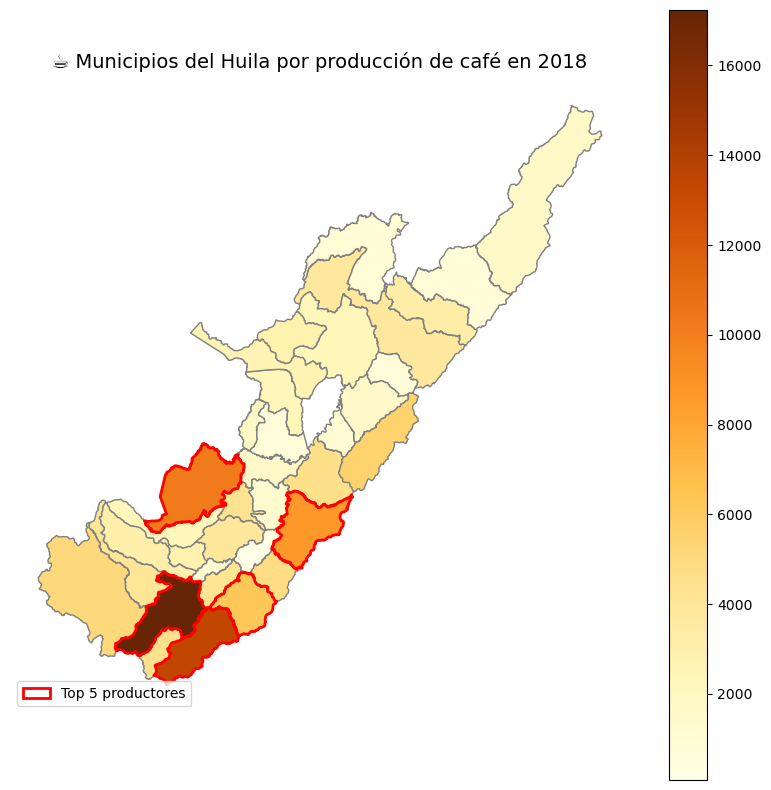

In [51]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ── Filtrar municipios del Huila ─────────────────────────────────────────────
cafe_huila = cafe[cafe["DPTO_CCDGO"] == "41"].copy()

print(f"Municipios del Huila con cultivo de café en {selected_year}: {len(cafe_huila)}")
print(cafe_huila[['MPIO_CNMBR', 'Producción\n(t)', 'yield_t_ha']])

# ── Obtener los 5 municipios más productores ─────────────────────────────────
top5_prod = cafe_huila.sort_values(by='Producción\n(t)', ascending=False).head(5)
print("\n🏆 Top 5 municipios productores de café en Huila:")
print(top5_prod[['MPIO_CNMBR', 'Producción\n(t)']])

# ── Graficar mapa ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 10))

# Colorear municipios por producción total
cafe_huila.plot(
    column="Producción\n(t)",
    ax=ax,
    cmap="YlOrBr",
    legend=True,
    edgecolor="gray"
)

# Resaltar los top 5 productores
top5_prod.plot(
    ax=ax,
    facecolor="none",
    edgecolor="red",
    linewidth=2
)

# Leyenda personalizada
legend_elements = [
    Patch(facecolor='none', edgecolor='red', linewidth=2, label='Top 5 productores')
]
ax.legend(handles=legend_elements, loc='lower left')

# Título y limpieza
ax.set_title(f"☕ Municipios del Huila por producción de café en {selected_year}", fontsize=14)
ax.axis("off")

plt.show()

# 4.7 Visualización local del la ubicacion del municipio de `Pitalito (Huila)`

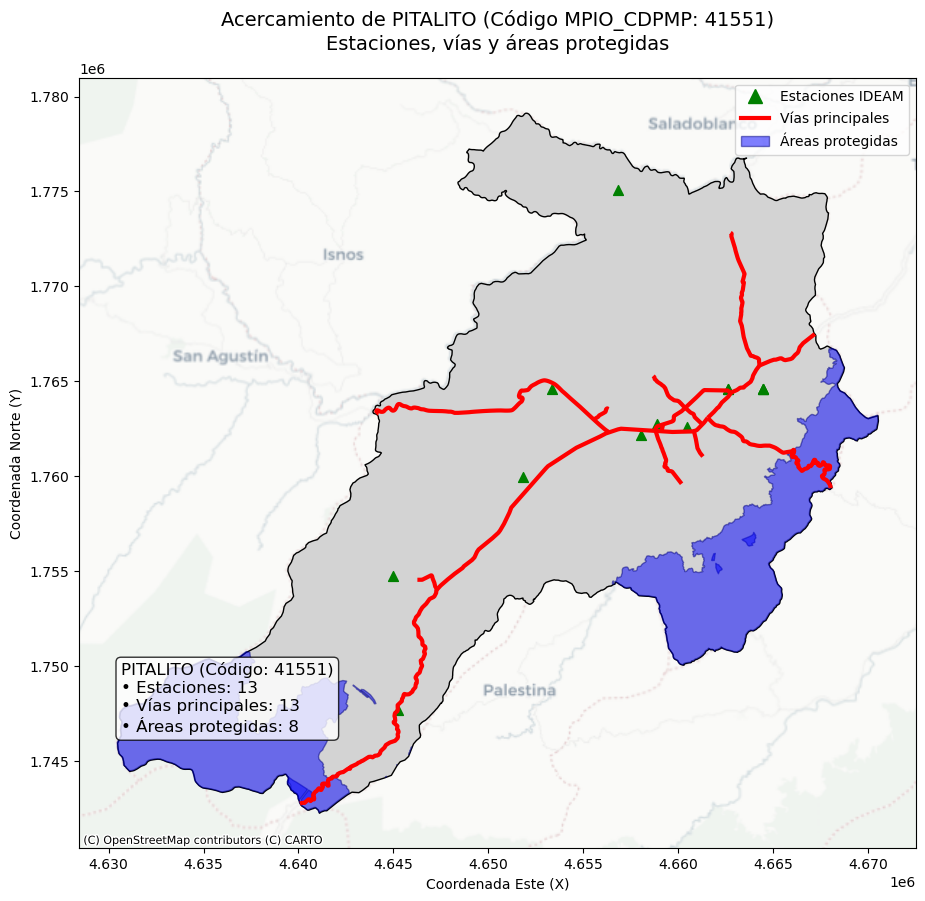

In [52]:
# --- Filtro para PITALITO ---
pitalito_muni = cafe[cafe["MPIO_CDPMP"] == "41551"].copy()

# --- Máscaras espaciales (intersección con geometría de Pitalito) ---
pitalito_stations = gdf_est[gdf_est.intersects(pitalito_muni.geometry.iloc[0])]
pitalito_vias     = gdf_vias[gdf_vias.intersects(pitalito_muni.geometry.iloc[0])]
pitalito_runap    = gdf_runap[gdf_runap.intersects(pitalito_muni.geometry.iloc[0])]

# --- Cortes al contorno del municipio ---
cort_via   = gpd.clip(pitalito_vias, pitalito_muni)
cort_runap = gpd.clip(pitalito_runap, pitalito_muni)  # ✅ aquí se recortan las áreas protegidas

# --- Mapa ---
fig, ax = plt.subplots(figsize=(12, 10))

# Capas base
pitalito_muni.plot(ax=ax, color="lightgray", edgecolor="black")
pitalito_stations.plot(ax=ax, color="green", markersize=50, marker="^")
cort_via.plot(ax=ax, color="red", linewidth=3)
cort_runap.plot(ax=ax, color="blue", alpha=0.5, edgecolor="navy")

# Base cartográfica
ctx.add_basemap(ax, crs=pitalito_muni.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Título y ejes
plt.title("Acercamiento de PITALITO (Código MPIO_CDPMP: 41551)\nEstaciones, vías y áreas protegidas", fontsize=14, pad=20)
ax.set_axis_on()
ax.ticklabel_format(useOffset=False)
ax.set_xlabel("Coordenada Este (X)")
ax.set_ylabel("Coordenada Norte (Y)")

# Anotación con resumen
info_text = (
    "PITALITO (Código: 41551)\n"
    f"• Estaciones: {len(pitalito_stations)}\n"
    f"• Vías principales: {len(cort_via)}\n"
    f"• Áreas protegidas: {len(cort_runap)}"
)
plt.annotate(
    info_text,
    xy=(0.05, 0.15),
    xycoords='axes fraction',
    fontsize=12,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

# Leyenda personalizada
custom_legend = [
    Line2D([0], [0], color='green', marker='^', linestyle='None', markersize=10, label='Estaciones IDEAM'),
    Line2D([0], [0], color='red', linewidth=3, label='Vías principales'),
    Patch(facecolor='blue', edgecolor='navy', alpha=0.5, label='Áreas protegidas')
]
ax.legend(handles=custom_legend, loc="upper right", fontsize=10)

plt.show()